In [ ]:
import pandas as pd, json, pathlib, itertools, collections
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.auto import tqdm
import plotly.express as px
import plotly.graph_objects as go
import imageio.v2 as imageio
from pathlib import Path
from natsort import natsorted     

In [10]:
import pandas as pd
import json
from pathlib import Path

# Paths to data folders and files
DATA_ROOT   = Path('results')                # Root directory for outputs
COMM_PATH   = DATA_ROOT / 'communities'      # Folder with community .jsons
PERF_CSV    = DATA_ROOT / 'performance.csv'  # Rolling performance log
PORT_JSON   = DATA_ROOT / 'portfolios.json'  # Portfolio weights

# Load each community .json file as a partition dict
def load_partitions(path=COMM_PATH):
    parts = {}
    for p in sorted(path.glob('*.json')):
        date = pd.to_datetime(p.stem)              # extract date from filename
        parts[date] = json.loads(p.read_text())    # load dict of {ticker: community_id}
    return pd.Series(parts, name='partition').sort_index()

# Load all artefacts
partitions = load_partitions()
performance = pd.read_csv(PERF_CSV, parse_dates=['date'])

with open(PORT_JSON) as fp:
    portfolios = json.load(fp)

# Correct way to count unique community IDs in a partition dict
print(f'{len(partitions)} time windows')
print(f'Communities per window: {len(set(partitions.iloc[0].values()))} – {len(set(partitions.iloc[-1].values()))}')

168 time windows
Communities per window: 11 – 12


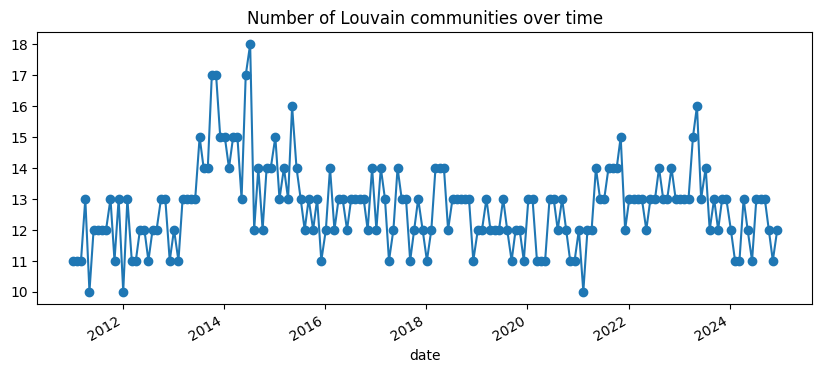

In [3]:
# number of communities over time
perf = performance.set_index('date').join(
    partitions.apply(lambda d: len(set(d.values()))).rename('n_comm_from_file')
)
perf[['n_comm','n_comm_from_file']].head()

plt.figure(figsize=(10,4))
perf['n_comm_from_file'].plot(marker='o')
plt.title('Number of Louvain communities over time')
plt.show()


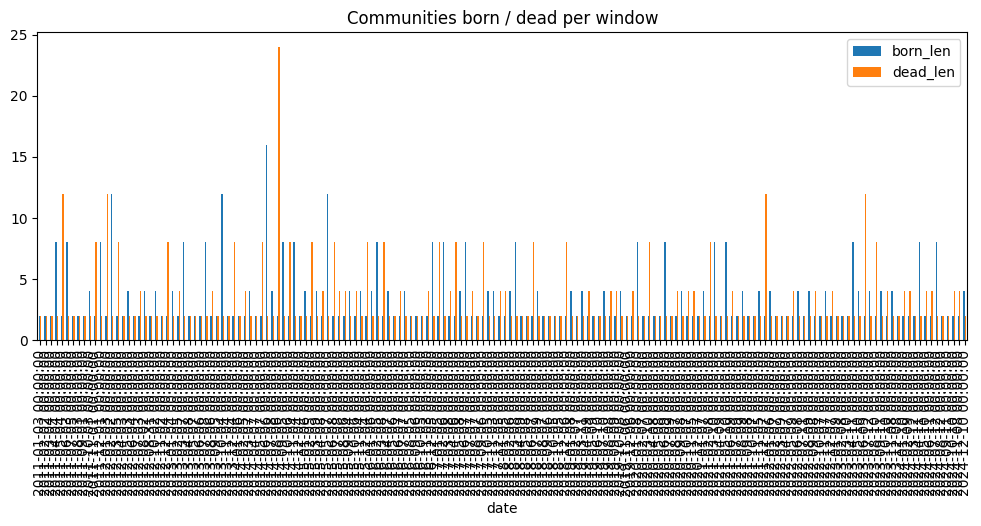

In [4]:
# Use ids in performance log
perf['born_len'] = perf['born'].str.len()
perf['dead_len'] = perf['dead'].str.len()

ax = perf[['born_len','dead_len']].plot(kind='bar', stacked=False, figsize=(12,4))
ax.set_title('Communities born / dead per window')
plt.show()


0it [00:00, ?it/s]

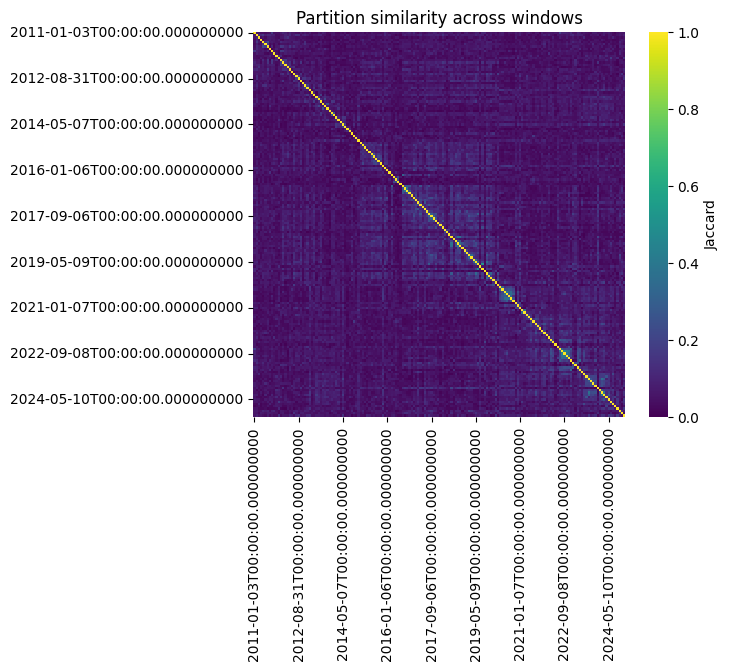

In [5]:
from itertools import combinations
import numpy as np

# pairwise Jaccard similarity between consecutive partitions
def jaccard(a,b):
    return len(a&b)/len(a|b) if a or b else 1.0

# Build similarity matrix
idx = partitions.index
sim = pd.DataFrame(index=idx, columns=idx, dtype=float)
for i,j in tqdm(combinations(range(len(idx)),2)):
    pi, pj = partitions.iloc[i], partitions.iloc[j]
    # flatten sets
    nodes = set(pi.keys()) & set(pj.keys())
    if not nodes:
        v = 0.0
    else:
        v = jaccard(set((pi[k],k) for k in nodes), set((pj[k],k) for k in nodes))
    sim.iat[i,j] = sim.iat[j,i] = v
sim.values[np.diag_indices_from(sim)] = 1.0

plt.figure(figsize=(6,5))
sns.heatmap(sim, cmap='viridis', cbar_kws={'label':'Jaccard'}, xticklabels=20, yticklabels=20)
plt.title('Partition similarity across windows')
plt.show()


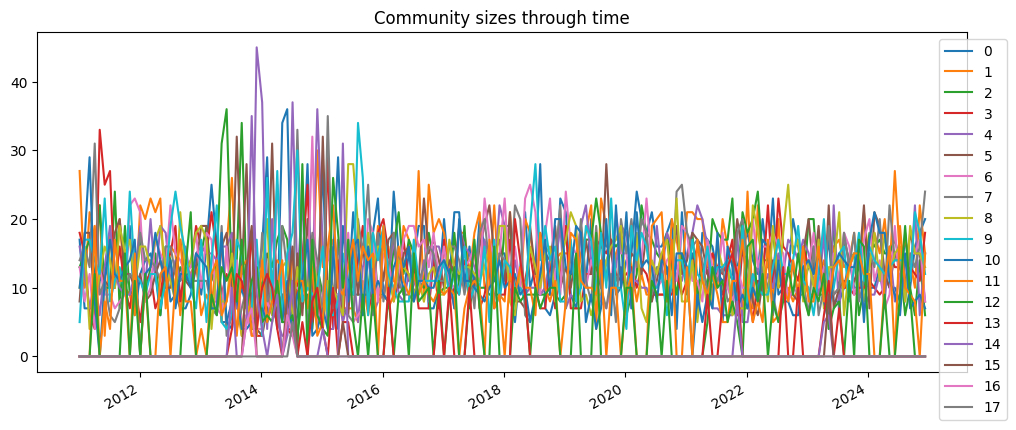

In [6]:
# Build dataframe: index=date, columns=community id, value=size
sizes = pd.DataFrame({
    d: pd.Series(collections.Counter(p.values()))
    for d,p in partitions.items()
}).T.fillna(0).astype(int)

sizes.plot(figsize=(12,5))
plt.title('Community sizes through time')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()


In [7]:
# Count how often each stock changed community
changes = collections.Counter()
for (prev, curr) in zip(partitions.iloc[:-1], partitions.iloc[1:]):
    for s in prev:
        if s in curr and prev[s]!=curr[s]:
            changes[s]+=1
change_series = pd.Series(changes).sort_values(ascending=False)
change_series.head(20)


EQIX     153
EQR      151
FRT      151
WELL     151
KIM      151
UDR      151
O        151
ESS      151
DLR      150
CMCSA    148
CCL      148
DIS      147
EXPE     147
PNC      146
RF       146
USB      146
SHW      146
SWK      145
SBUX     145
HST      145
dtype: int64

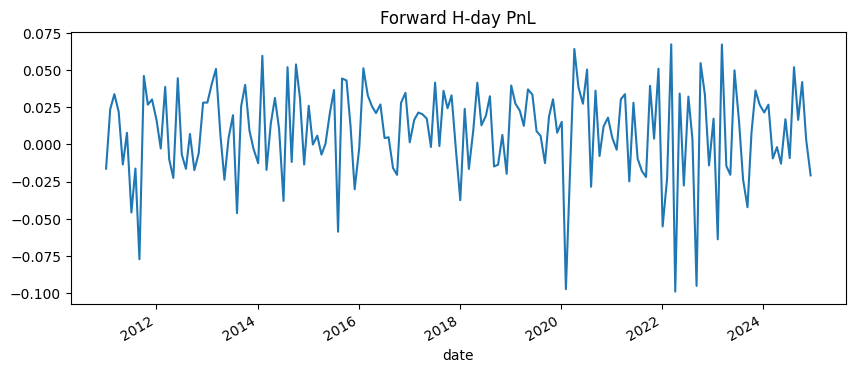

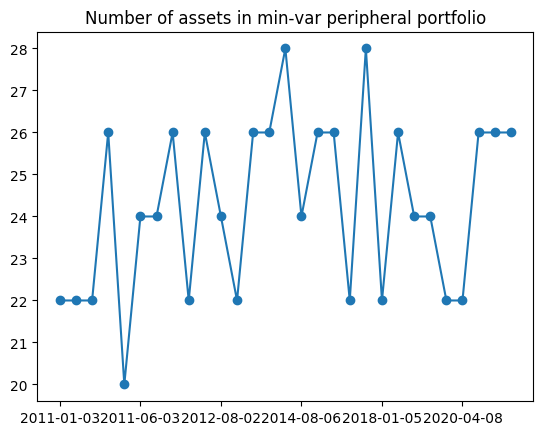

In [8]:
# Example: plot PnL and portfolio sparsity
perf['pnl'].plot(figsize=(10,4), title='Forward H‑day PnL')
plt.show()

w_counts = pd.Series({d: len(w) for d,w in portfolios.items()})
w_counts.plot(style='o-')
plt.title('Number of assets in min‑var peripheral portfolio')
plt.show()


In [14]:
from collections import defaultdict
import pandas as pd
import plotly.graph_objects as go
import json
from pathlib import Path

# Load partitions with proper datetime index
COMM_PATH = Path("results/communities")
parts = {}
for p in sorted(COMM_PATH.glob("*.json")):
    date = pd.to_datetime(p.stem)
    with open(p) as fp:
        parts[date] = json.load(fp)
partitions = pd.Series(parts, name="partition")
partitions.index = pd.to_datetime(partitions.index)  # Ensure datetime index

# Build Sankey data for a given year
def build_sankey_data(partitions, year):
    year_parts = partitions[partitions.index.year == year]
    if len(year_parts) < 2:
        return None

    labels = []
    index_map = {}
    flows = defaultdict(int)

    # Generate node labels
    for t_idx, (t, part) in enumerate(year_parts.items()):
        for stock, cid in part.items():
            label = f"{t.strftime('%b')}-{cid}"
            if label not in index_map:
                index_map[label] = len(labels)
                labels.append(label)

    # Flow between consecutive windows
    for (t1, p1), (t2, p2) in zip(year_parts.items(), list(year_parts.items())[1:]):
        comm1 = defaultdict(set)
        comm2 = defaultdict(set)
        for k, v in p1.items():
            comm1[v].add(k)
        for k, v in p2.items():
            comm2[v].add(k)

        for c1, stocks1 in comm1.items():
            for c2, stocks2 in comm2.items():
                inter = stocks1 & stocks2
                if inter:
                    l1 = f"{t1.strftime('%b')}-{c1}"
                    l2 = f"{t2.strftime('%b')}-{c2}"
                    flows[(l1, l2)] += len(inter)

    sources, targets, values = [], [], []
    for (src, tgt), val in flows.items():
        sources.append(index_map[src])
        targets.append(index_map[tgt])
        values.append(val)

    sankey_fig = go.Figure(data=[go.Sankey(
        node=dict(label=labels, pad=15, thickness=20),
        link=dict(source=sources, target=targets, value=values)
    )])
    sankey_fig.update_layout(title_text=f"Community Evolution — {year}", font_size=10)
    return sankey_fig

# Generate and save all Sankey plots
years = sorted(set(partitions.index.map(lambda x: x.year)))
output_paths = []
for year in years:
    fig = build_sankey_data(partitions, year)
    if fig:
        out = Path(f"results/sankey/sankey_communities_{year}.html")
        fig.write_html(str(out))
        output_paths.append(str(out))

output_paths


['results/sankey/sankey_communities_2011.html',
 'results/sankey/sankey_communities_2012.html',
 'results/sankey/sankey_communities_2013.html',
 'results/sankey/sankey_communities_2014.html',
 'results/sankey/sankey_communities_2015.html',
 'results/sankey/sankey_communities_2016.html',
 'results/sankey/sankey_communities_2017.html',
 'results/sankey/sankey_communities_2018.html',
 'results/sankey/sankey_communities_2019.html',
 'results/sankey/sankey_communities_2020.html',
 'results/sankey/sankey_communities_2021.html',
 'results/sankey/sankey_communities_2022.html',
 'results/sankey/sankey_communities_2023.html',
 'results/sankey/sankey_communities_2024.html']

In [15]:
# Load the S&P 500 company info file
company_df = pd.read_csv("data/sp500_companies.csv")

# Preview structure and check available fields
company_df.head(), company_df.columns

(  Exchange Symbol              Shortname               Longname  \
 0      NMS   AAPL             Apple Inc.             Apple Inc.   
 1      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
 2      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
 3      NMS   AMZN       Amazon.com, Inc.       Amazon.com, Inc.   
 4      NMS  GOOGL          Alphabet Inc.          Alphabet Inc.   
 
                    Sector                        Industry  Currentprice  \
 0              Technology            Consumer Electronics        254.49   
 1              Technology                  Semiconductors        134.70   
 2              Technology       Software - Infrastructure        436.60   
 3       Consumer Cyclical                 Internet Retail        224.92   
 4  Communication Services  Internet Content & Information        191.41   
 
        Marketcap        Ebitda  Revenuegrowth           City State  \
 0  3846819807232  1.346610e+11          0.061      Cupertino

In [16]:
partitions = pd.Series(partitions).sort_index()

In [17]:
partitions = pd.Series(partitions, name="partition")
partitions.index = pd.to_datetime(partitions.index)  # enforce datetime index
partitions = partitions.sort_index()

In [18]:
years = sorted(set(partitions.index.year))

In [25]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import json
from pathlib import Path

# Load community partitions
COMM_PATH = Path("results/communities")
partitions = {}
for p in sorted(COMM_PATH.glob("*.json")):
    date = pd.to_datetime(p.stem)
    with open(p) as fp:
        partitions[date] = json.load(fp)
partitions = pd.Series(partitions, name="partition")
partitions.index = pd.to_datetime(partitions.index)
partitions = partitions.sort_index()

# Load sector metadata
company_df = pd.read_csv("data/sp500_companies.csv")
sector_map = {k.upper(): v for k, v in company_df.set_index("Symbol")["Sector"].items()}

# Ensure output folder exists
output_dir = Path("results/sector")
output_dir.mkdir(parents=True, exist_ok=True)

# Generate plots
years = sorted(set(partitions.index.year))
output_paths = []

for year in years:
    year_parts = partitions[partitions.index.year == year]
    n = len(year_parts)
    if n == 0:
        continue

    fig, axes = plt.subplots(nrows=(n + 2) // 3, ncols=3, figsize=(16, 4 * ((n + 2) // 3)))
    axes = axes.flatten()
    last_ax = None

    for ax, (dt, part) in zip(axes, year_parts.items()):
        community_sector_counts = defaultdict(lambda: defaultdict(int))
        for stock, cid in part.items():
            sector = sector_map.get(stock.upper(), "Unknown")
            community_sector_counts[cid][sector] += 1

        df = pd.DataFrame(community_sector_counts).fillna(0).astype(int)
        if df.empty:
            continue

        df = df.reindex(df.sum(axis=1).sort_values(ascending=False).index)

        df.T.plot(kind="bar", stacked=True, ax=ax, width=0.8, colormap="tab20", legend=False)
        ax.set_title(dt.strftime("%Y-%m-%d"))
        ax.set_xlabel("Community ID")
        ax.set_ylabel("Sector count")
        last_ax = ax  # save for shared legend

    for i in range(len(year_parts), len(axes)):
        fig.delaxes(axes[i])

    if last_ax:
        handles, labels = last_ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=5, fontsize='medium', bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f"Sector composition by community – {year}", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    out_path = output_dir / f"sector_by_community_{year}.png"
    fig.savefig(out_path)
    plt.close(fig)
    output_paths.append(str(out_path))

output_paths


['results/sector/sector_by_community_2011.png',
 'results/sector/sector_by_community_2012.png',
 'results/sector/sector_by_community_2013.png',
 'results/sector/sector_by_community_2014.png',
 'results/sector/sector_by_community_2015.png',
 'results/sector/sector_by_community_2016.png',
 'results/sector/sector_by_community_2017.png',
 'results/sector/sector_by_community_2018.png',
 'results/sector/sector_by_community_2019.png',
 'results/sector/sector_by_community_2020.png',
 'results/sector/sector_by_community_2021.png',
 'results/sector/sector_by_community_2022.png',
 'results/sector/sector_by_community_2023.png',
 'results/sector/sector_by_community_2024.png']

In [26]:
from scipy.stats import entropy

def community_sector_entropy(partition, sector_map):
    cid_sectors = defaultdict(list)
    for stock, cid in partition.items():
        sec = sector_map.get(stock.upper(), "Unknown")
        cid_sectors[cid].append(sec)
    
    return {cid: entropy(pd.Series(secs).value_counts(normalize=True)) 
            for cid, secs in cid_sectors.items()}

In [27]:
# returns: {time: {community_id: {sector: proportion}}}
def sector_proportions(partitions, sector_map):
    result = {}
    for t, part in partitions.items():
        c_table = defaultdict(lambda: defaultdict(int))
        for stock, cid in part.items():
            sec = sector_map.get(stock.upper(), "Unknown")
            c_table[cid][sec] += 1
        # normalize
        c_props = {
            cid: {s: v/sum(secs.values()) for s,v in secs.items()}
            for cid, secs in c_table.items()
        }
        result[t] = c_props
    return result

In [28]:
from collections import Counter

def sector_to_comm_matrix(partitions, sector_map, sector):
    dates = []
    counts = []

    for dt, part in partitions.items():
        comm_counter = Counter()
        for stock, cid in part.items():
            if sector_map.get(stock.upper(), "Unknown") == sector:
                comm_counter[cid] += 1
        dates.append(dt)
        counts.append(comm_counter)

    return pd.DataFrame(counts, index=dates).fillna(0).astype(int)

In [29]:
from collections import defaultdict

def sector_churn(partitions, sector_map):
    churns = defaultdict(int)
    prev = None
    for part in partitions:
        if prev is None:
            prev = part
            continue
        for stock in prev:
            if stock in part and prev[stock] != part[stock]:
                sector = sector_map.get(stock.upper(), "Unknown")
                churns[sector] += 1
        prev = part
    return pd.Series(churns).sort_values(ascending=False)

In [31]:
# One snapshot
t = partitions.index[0]
entropy_dict = community_sector_entropy(partitions[t], sector_map)
pd.Series(entropy_dict).sort_index()

0     1.222267
1     2.064238
2     1.265857
3     0.633663
4     1.363363
5     0.000000
6     1.778233
7     1.635743
8     0.801819
9     1.054920
10    0.639032
dtype: float64

In [32]:
sector_prop = sector_proportions(partitions, sector_map)

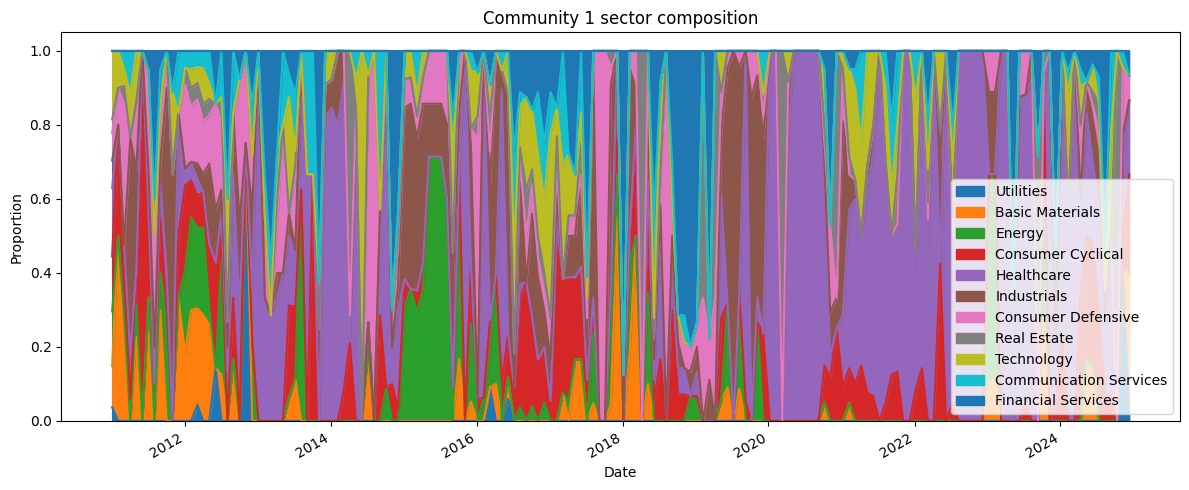

In [48]:
# Get sector proportions for community 0 over time
community_id = 1
df = pd.DataFrame({
    t: props.get(community_id, {}) for t, props in sector_prop.items()
}).T.fillna(0)

df.plot.area(figsize=(12, 5), title=f"Community {community_id} sector composition")
plt.xlabel("Date")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

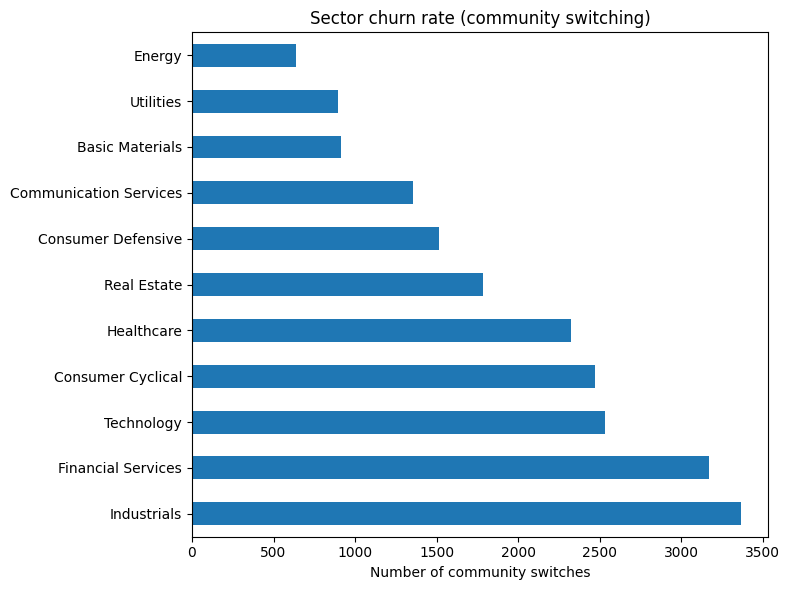

In [47]:
churn = sector_churn(partitions, sector_map)
churn.plot.barh(figsize=(8, 6), title="Sector churn rate (community switching)")
plt.xlabel("Number of community switches")
plt.tight_layout()
plt.show()

In [6]:
png_dir  = Path("results/communities")         # folder with your per‑window PNGs
png_files = natsorted(png_dir.glob("*.png"))    # natural sort by date

frames = [imageio.imread(p) for p in png_files]
imageio.mimsave("results/communities_evolution.gif", frames, duration=1.0)  # 1s each
print("GIF saved to results/communities_evolution.gif")

GIF saved to results/communities_evolution.gif
